<div style='background-color: #e6f7ff; border: 4px solid #0078FF; border-radius: 12px; padding: 10px; text-align: center;'>
<font size="+2" color="#0078FF">
<b>🌟 Enjoyed this notebook? Please <span style='color: #FF4500;'>comment</span> & <span style='color: #32CD32;'>upvote</span>! 🌟</b>
</font>
</div>

<div style='background-color: #fff0f5; border: 4px solid #FF69B4; border-radius: 12px; padding: 10px; text-align: center; margin-top: 10px;'>
<font size="+2" color="#FF69B4">
<b>💻 Explore more in my profile ➔
<a href="https://www.kaggle.com/killa92/code" style='color: #0078FF; text-decoration: none; font-weight: bold;'>Kaggle Notebooks</a> 💻</b>
</font>
</div>

<div style='background-color: #f0fff0; border: 4px solid #32CD32; border-radius: 12px; padding: 10px; text-align: center; margin-top: 10px;'>
<font size="+2" color="#32CD32">
<b>🤝 Let's grow together and inspire each other! 🚀</b>
</font>
</div>

<div style='background-color: #e6f7ff; border: 3px solid #0078FF; border-radius: 10px; padding: 8px; text-align: center;'>
<font size="+2" color="#0078FF"><b>🗂️ 1. Custom Datasets & DataLoaders 🗂️</b></font>
</div>

In [1]:
import os
import torch
import numpy as np
from glob import glob
from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T

torch.manual_seed(2025)

class CustomDataset(Dataset):
    def __init__(self, root, data_type, transformations=None, im_files=[".png", ".jpg"]):
        
        self.transformations, self.data_type = transformations, data_type
        self.im_paths = [im_path for im_path in glob(f"{root}/{data_type}/*/*{[im_file for im_file in im_files]}")]        

        self.cls_names, self.cls_counts = {}, {}
        count = 0
        for im_path in self.im_paths:
            class_name = self.get_class(im_path)
            if class_name not in self.cls_names:
                self.cls_names[class_name] = count
                self.cls_counts[class_name] = 1
                count += 1
            else:
                self.cls_counts[class_name] += 1        
        
    def get_class(self, path): return os.path.dirname(path).split("/")[-1]

    def __len__(self): return len(self.im_paths)

    def __getitem__(self, idx):
        
        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB")        

        if self.transformations: im = self.transformations(im)        
        gt = self.cls_names[self.get_class(im_path)]
        return im, gt        
        

    @classmethod
    def get_dls(cls, root, transformations, bs, split=[0.9, 0.05, 0.05], ns=4):
        
        tr_ds = cls(root=root, data_type="train", transformations=transformations)
        ts_ds = cls(root=root, data_type="test", transformations=transformations)
        cls_names, cls_counts = tr_ds.cls_names, tr_ds.cls_counts

        total_len = len(tr_ds)
        tr_len = int(total_len * split[0])
        vl_len = total_len - tr_len        

        tr_ds, vl_ds = random_split(tr_ds, [tr_len, vl_len])

        tr_dl = DataLoader(tr_ds, batch_size=bs, shuffle=True, num_workers=ns)
        val_dl = DataLoader(vl_ds, batch_size=bs, shuffle=False, num_workers=ns)
        ts_dl = DataLoader(ts_ds, batch_size=1, shuffle=False, num_workers=ns)

        return tr_dl, val_dl, ts_dl, cls_names, [cls_counts]

root = "/kaggle/input/fruit-ripeness-unripe-ripe-and-rotten/archive (1)/dataset/dataset"
mean, std, im_size, bs = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 64, 32
tfs = T.Compose([T.Resize((im_size, im_size)), T.ToTensor(), T.Normalize(mean=mean, std=std)])

tr_dl, val_dl, ts_dl, classes, cls_counts = CustomDataset.get_dls(root=root, transformations=tfs, bs=bs)
print(len(tr_dl)); print(len(val_dl)); print(len(ts_dl)); print(classes)

481
54
3889
{'rottenbanana': 0, 'freshoranges': 1, 'rottenoranges': 2, 'unripe apple': 3, 'unripe banana': 4, 'freshbanana': 5, 'rottenapples': 6, 'freshapples': 7, 'unripe orange': 8}


<div style='background-color: #ffe6f2; border: 3px solid #ff1493; border-radius: 10px; padding: 8px; text-align: center;'>
<font size="+2" color="#ff1493"><b>📈 2. Data Analysis 📈</b></font>
</div>

Data analysis is in process...



<ipython-input-2-d49c985fdab8>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(cls_names, rotation = 90)


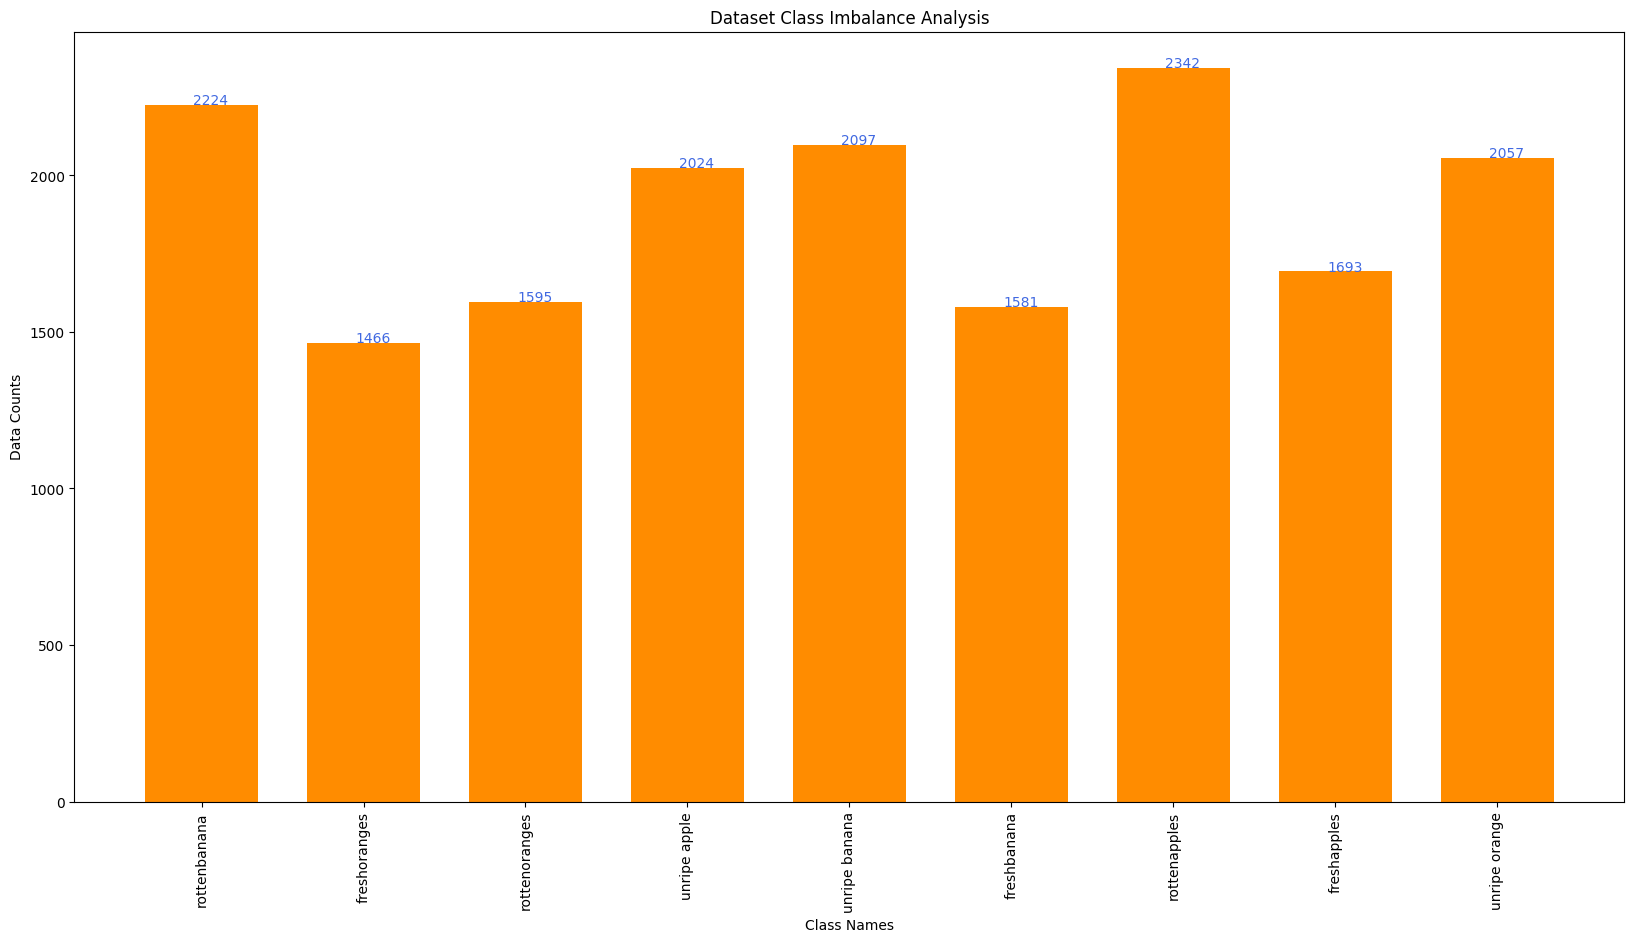

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from torchvision import transforms as T

class Visualization:

    def __init__(self, vis_datas, n_ims, rows, cmap=None, cls_names=None, cls_counts=None, t_type="rgb"):
        self.n_ims, self.rows = n_ims, rows
        self.t_type, self.cmap = t_type, cmap
        self.cls_names = cls_names
        self.colors = ["darkorange", "seagreen", "salmon"] 
        
        data_names = ["train", "val", "test"]
        self.vis_datas = {data_names[i]: vis_datas[i] for i in range(len(vis_datas))}
        if isinstance(cls_counts, list): 
            self.analysis_datas = {data_names[i]: cls_counts[i] for i in range(len(cls_counts))}
        else: 
            self.analysis_datas = {"all": cls_counts}

    def tn2np(self, t):
        gray_tfs = T.Compose([T.Normalize(mean=[0.], std=[1/0.5]), T.Normalize(mean=[-0.5], std=[1])])
        rgb_tfs = T.Compose([T.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]), 
                             T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])])
        
        invTrans = gray_tfs if self.t_type == "gray" else rgb_tfs
        
        return (invTrans(t) * 255).detach().squeeze().cpu().permute(1, 2, 0).numpy().astype(np.uint8) if self.t_type == "gray" \
               else (invTrans(t) * 255).detach().cpu().permute(1, 2, 0).numpy().astype(np.uint8)

    def plot(self, rows, cols, count, im, title="Original Image"):
        plt.subplot(rows, cols, count)
        plt.imshow(self.tn2np(im))
        plt.axis("off")
        plt.title(title)
        return count + 1

    def vis(self, data, save_name):
        print(f"{save_name.upper()} Data Visualization is in process...\n")
        assert self.cmap in ["rgb", "gray"], "Please choose rgb or gray cmap"
        cmap = "viridis" if self.cmap == "rgb" else None
        cols = self.n_ims // self.rows
        count = 1

        plt.figure(figsize=(25, 20))
        indices = [np.random.randint(low=0, high=len(data) - 1) for _ in range(self.n_ims)]

        for idx, index in enumerate(indices):
            if count == self.n_ims + 1: break
            image, label = data[index]
            plt.subplot(self.rows, self.n_ims // self.rows, idx + 1)

            if cmap:
                plt.imshow(self.tn2np(image), cmap=cmap)
            else:
                plt.imshow(self.tn2np(image))

            plt.axis('off')
            if self.cls_names is not None:
                plt.title(f"GT -> {self.cls_names[int(label)]}")
            else:
                plt.title(f"GT -> {label}")
        
        plt.show()

    def data_analysis(self, cls_counts, save_name, color):
        print("Data analysis is in process...\n")
        width, text_width, text_height = 0.7, 0.05, 2
        cls_names = list(cls_counts.keys())
        counts = list(cls_counts.values())
        _, ax = plt.subplots(figsize=(20, 10))
        indices = np.arange(len(counts))
        ax.bar(indices, counts, width, color=color)
        ax.set_xlabel("Class Names", color="black")
        ax.set_xticklabels(cls_names, rotation = 90)
        ax.set(xticks=indices, xticklabels=cls_names)
        ax.set_ylabel("Data Counts", color="black")
        ax.set_title("Dataset Class Imbalance Analysis")
        for i, v in enumerate(counts):
            ax.text(i - text_width, v + text_height, str(v), color="royalblue")
    
    def plot_pie_chart(self, cls_counts):
        print("Generating pie chart...\n")
        labels = list(cls_counts.keys())
        sizes = list(cls_counts.values())
        explode = [0.1] * len(labels)  # To highlight all slices equally (optional)
        
        plt.figure(figsize=(8, 8))
        plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
        plt.title("Class Distribution")
        plt.axis("equal")  # Equal aspect ratio ensures the pie chart is circular
        plt.show()

    def visualization(self): [self.vis(data.dataset, save_name) for (save_name, data) in self.vis_datas.items()]
        
    def analysis(self): [self.data_analysis(data, save_name, color) for (save_name, data), color in zip(self.analysis_datas.items(), self.colors)]

    def pie_chart(self): [self.plot_pie_chart(data) for data in self.analysis_datas.values()]
        
vis = Visualization(vis_datas = [tr_dl, ts_dl], n_ims = 18, rows = 6, cmap = "rgb", cls_names = list(classes.keys()), cls_counts = cls_counts)
vis.analysis()

Generating pie chart...



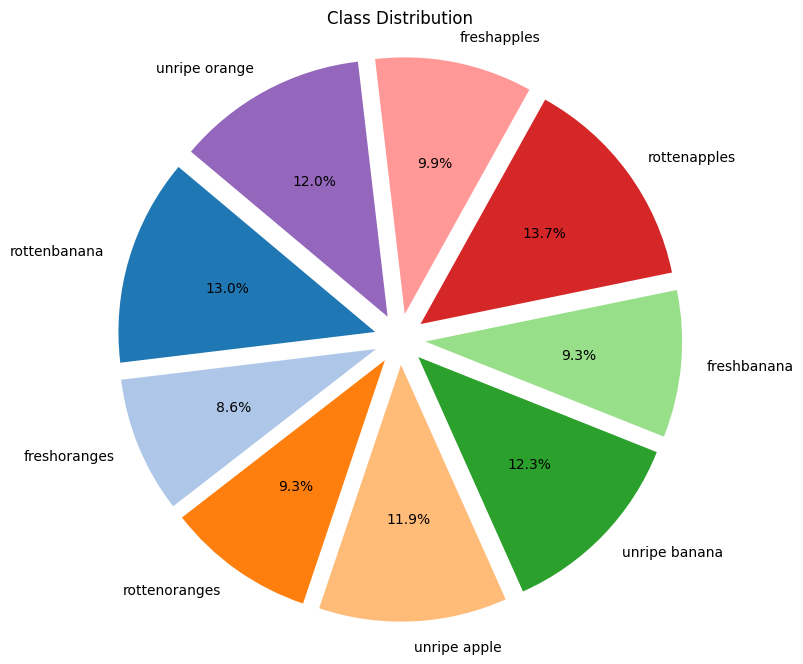

In [3]:
vis.pie_chart()

<div style='background-color: #e6f7ff; border: 3px solid #007acc; border-radius: 10px; padding: 8px; text-align: center;'>
<font size="+2" color="#007acc"><b>📊 3. Data Visualization 📊</b></font>
</div>

TRAIN Data Visualization is in process...



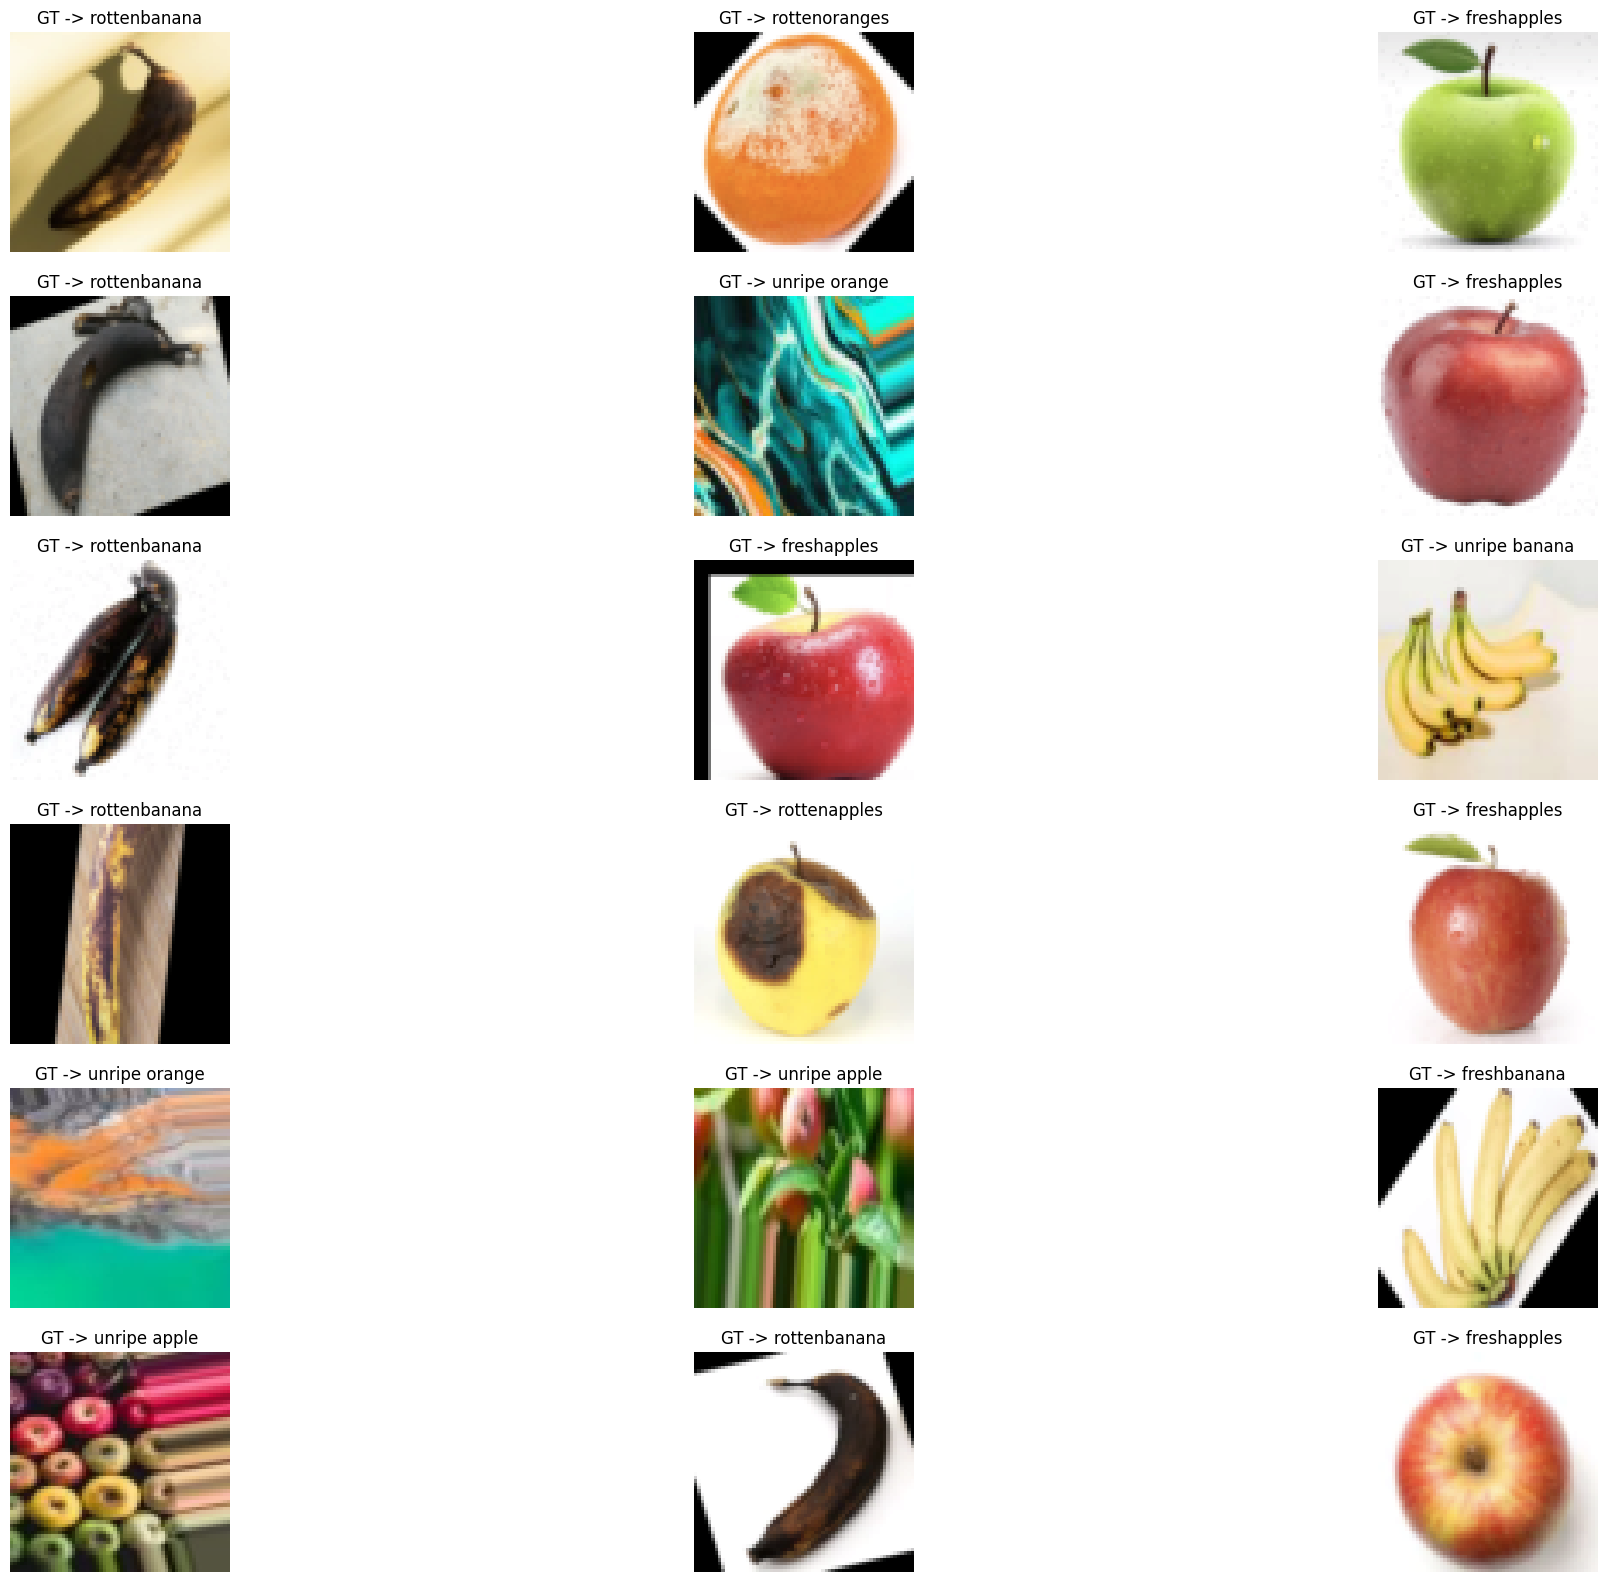

VAL Data Visualization is in process...



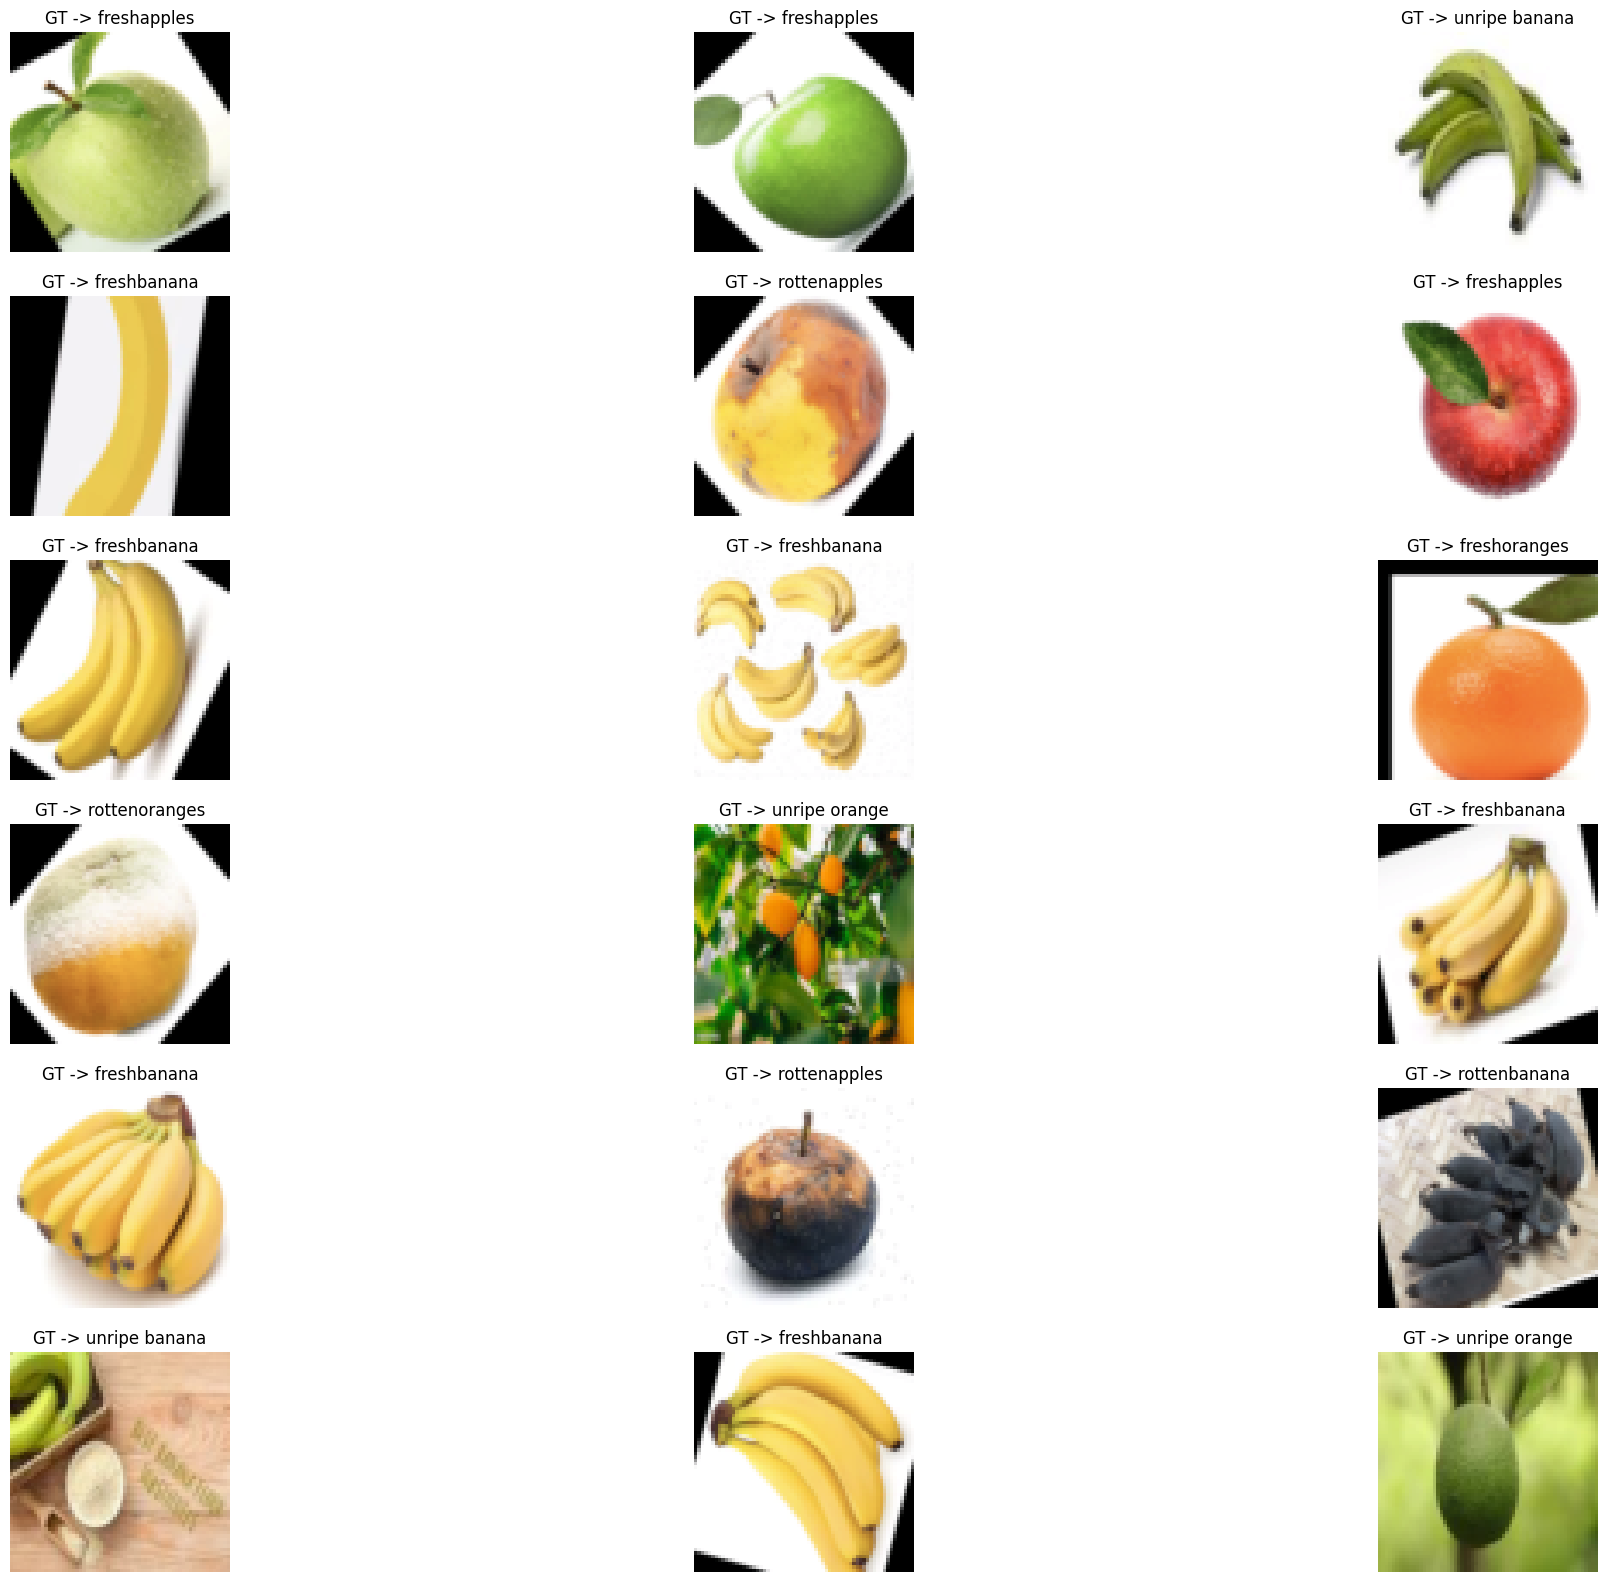

In [4]:
vis.visualization()

<div style='background-color: #f0f9e8; border: 3px solid #4CAF50; border-radius: 10px; padding: 8px; text-align: center;'>
<font size="+2" color="#4CAF50"><b>✨ 4. AI Model Train and Validation ✨</b></font>
</div>

In [5]:
import os, torchmetrics
import timm
from tqdm import tqdm

class TrainValidation:
    def __init__(self, model_name, classes, tr_dl, val_dl, device, save_dir="saved_models", save_prefix="model", lr=3e-4, epochs=50, patience=5, threshold=0.01, dev_mode = False):
        self.model_name = model_name
        self.classes = classes
        self.tr_dl = tr_dl
        self.val_dl = val_dl
        self.save_dir = save_dir
        self.save_prefix = save_prefix
        self.lr = lr
        self.epochs = epochs
        self.patience = patience
        self.threshold = threshold
        self.dev_mode = dev_mode
        self.device = device
        self.model = timm.create_model(model_name, pretrained=True, num_classes=len(classes)).to(self.device)
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.f1_metric = torchmetrics.F1Score(task="multiclass", num_classes=len(classes)).to(self.device)

        os.makedirs(save_dir, exist_ok=True)

        self.best_loss = float("inf")
        self.best_acc = 0
        self.not_improved = 0

        self.tr_losses, self.val_losses = [], []
        self.tr_accs, self.val_accs = [], []
        self.tr_f1s, self.val_f1s = [], []

    @staticmethod
    def to_device(batch, device):
        ims, gts = batch
        return ims.to(device), gts.to(device)

    def train_epoch(self):
        self.model.train()
        train_loss, train_acc = 0.0, 0.0
        self.f1_metric.reset()

        for idx, batch in tqdm(enumerate(self.tr_dl), desc="Training"):
            if self.dev_mode: 
                if idx == 1: break
            
            ims, gts = TrainValidation.to_device(batch = batch, device = self.device)
            # ims, gts = self.to_device((ims, gts))
            
            # Forward pass
            preds = self.model(ims)
            loss = self.loss_fn(preds, gts)
            
            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            # Update metrics
            train_loss += loss.item()
            train_acc += (torch.argmax(preds, dim=1) == gts).sum().item()
            self.f1_metric.update(preds, gts)

        train_loss /= len(self.tr_dl)
        train_acc /= len(self.tr_dl.dataset)
        train_f1 = self.f1_metric.compute().item()
        
        self.tr_losses.append(train_loss)
        self.tr_accs.append(train_acc)
        self.tr_f1s.append(train_f1)

        return train_loss, train_acc, train_f1

    def validate_epoch(self):
        self.model.eval()
        val_loss, val_acc = 0.0, 0.0
        self.f1_metric.reset()

        with torch.no_grad():
            for idx, batch in tqdm(enumerate(self.val_dl), desc="Validation"):
                if self.dev_mode: 
                    if idx == 1: break
                # ims, gts = self.to_device((ims, gts))
                ims, gts = TrainValidation.to_device(batch, device = self.device)
                preds = self.model(ims)
                loss = self.loss_fn(preds, gts)

                # Update metrics
                val_loss += loss.item()
                val_acc += (torch.argmax(preds, dim=1) == gts).sum().item()
                self.f1_metric.update(preds, gts)

        val_loss /= len(self.val_dl)
        val_acc /= len(self.val_dl.dataset)
        val_f1 = self.f1_metric.compute().item()

        self.val_losses.append(val_loss)
        self.val_accs.append(val_acc)
        self.val_f1s.append(val_f1)

        return val_loss, val_acc, val_f1

    def save_best_model(self, val_f1, val_loss):
        if val_f1 > self.best_acc + self.threshold:
            self.best_acc = val_f1            
            save_path = os.path.join(self.save_dir, f"{self.save_prefix}_best_model.pth")
            torch.save(self.model.state_dict(), save_path)
            print(f"Best model saved with F1-Score: {self.best_acc:.3f}")
            self.not_improved = 0
        else:
            self.not_improved += 1
            print(f"No improvement for {self.not_improved} epoch(s).")

    def verbose(self, epoch, metric1, metric2, metric3, process = "train"):

        print(f"{epoch + 1}-epoch {process} process is completed!\n")
        print(f"{epoch + 1}-epoch {process} loss          -> {metric1:.3f}")
        print(f"{epoch + 1}-epoch {process} accuracy      -> {metric2:.3f}")
        print(f"{epoch + 1}-epoch {process} f1-score      -> {metric3:.3f}\n")
    
    def run(self):
        print("Start training...")

        for epoch in range(self.epochs):
            if self.dev_mode: 
                if epoch == 1: break 
                    
            print(f"\nEpoch {epoch + 1}/{self.epochs}:\n")

            train_loss, train_acc, train_f1 = self.train_epoch()
            self.verbose(epoch, train_loss, train_acc, train_f1, process = "train")

            val_loss, val_acc, val_f1 = self.validate_epoch()
            self.verbose(epoch, val_loss, val_acc, val_f1, process = "validation")            

            self.save_best_model(val_f1, val_loss)

            if self.not_improved >= self.patience:
                print("Early stopping triggered.")
                break

model_name   = "rexnet_150"
save_prefix  = "fruits"
save_dir     = "saved_models"
device       = "cuda" if torch.cuda.is_available() else "cpu"

trainer = TrainValidation(model_name = model_name, device = device, 
                          save_prefix = save_prefix, classes = classes, 
                          patience = 3, tr_dl = tr_dl, val_dl = val_dl, dev_mode = False)
trainer.run()

model.safetensors:   0%|          | 0.00/39.2M [00:00<?, ?B/s]

Start training...

Epoch 1/50:



Training: 481it [00:37, 12.91it/s]

1-epoch train process is completed!

1-epoch train loss          -> 0.723
1-epoch train accuracy      -> 0.818
1-epoch train f1-score      -> 0.818




Validation: 54it [00:04, 13.33it/s]

1-epoch validation process is completed!

1-epoch validation loss          -> 0.140
1-epoch validation accuracy      -> 0.950
1-epoch validation f1-score      -> 0.950

Best model saved with F1-Score: 0.950

Epoch 2/50:




Training: 481it [00:27, 17.33it/s]

2-epoch train process is completed!

2-epoch train loss          -> 0.141
2-epoch train accuracy      -> 0.952
2-epoch train f1-score      -> 0.952




Validation: 54it [00:02, 19.43it/s]

2-epoch validation process is completed!

2-epoch validation loss          -> 0.081
2-epoch validation accuracy      -> 0.967
2-epoch validation f1-score      -> 0.967

Best model saved with F1-Score: 0.967

Epoch 3/50:




Training: 481it [00:28, 16.98it/s]

3-epoch train process is completed!

3-epoch train loss          -> 0.074
3-epoch train accuracy      -> 0.976
3-epoch train f1-score      -> 0.976




Validation: 54it [00:02, 19.03it/s]

3-epoch validation process is completed!

3-epoch validation loss          -> 0.091
3-epoch validation accuracy      -> 0.972
3-epoch validation f1-score      -> 0.972

No improvement for 1 epoch(s).

Epoch 4/50:




Training: 481it [00:27, 17.24it/s]

4-epoch train process is completed!

4-epoch train loss          -> 0.046
4-epoch train accuracy      -> 0.985
4-epoch train f1-score      -> 0.985




Validation: 54it [00:02, 18.71it/s]


4-epoch validation process is completed!

4-epoch validation loss          -> 0.089
4-epoch validation accuracy      -> 0.975
4-epoch validation f1-score      -> 0.975

No improvement for 2 epoch(s).

Epoch 5/50:



Training: 481it [00:27, 17.42it/s]

5-epoch train process is completed!

5-epoch train loss          -> 0.057
5-epoch train accuracy      -> 0.983
5-epoch train f1-score      -> 0.983




Validation: 54it [00:02, 19.34it/s]


5-epoch validation process is completed!

5-epoch validation loss          -> 0.071
5-epoch validation accuracy      -> 0.977
5-epoch validation f1-score      -> 0.977

Best model saved with F1-Score: 0.977

Epoch 6/50:



Training: 481it [00:27, 17.41it/s]

6-epoch train process is completed!

6-epoch train loss          -> 0.049
6-epoch train accuracy      -> 0.985
6-epoch train f1-score      -> 0.985




Validation: 54it [00:02, 20.21it/s]

6-epoch validation process is completed!

6-epoch validation loss          -> 0.092
6-epoch validation accuracy      -> 0.974
6-epoch validation f1-score      -> 0.974

No improvement for 1 epoch(s).

Epoch 7/50:




Training: 481it [00:27, 17.52it/s]

7-epoch train process is completed!

7-epoch train loss          -> 0.043
7-epoch train accuracy      -> 0.986
7-epoch train f1-score      -> 0.986




Validation: 54it [00:02, 20.49it/s]

7-epoch validation process is completed!

7-epoch validation loss          -> 0.082
7-epoch validation accuracy      -> 0.977
7-epoch validation f1-score      -> 0.977

No improvement for 2 epoch(s).

Epoch 8/50:




Training: 481it [00:27, 17.80it/s]

8-epoch train process is completed!

8-epoch train loss          -> 0.047
8-epoch train accuracy      -> 0.985
8-epoch train f1-score      -> 0.985




Validation: 54it [00:02, 19.79it/s]

8-epoch validation process is completed!

8-epoch validation loss          -> 0.063
8-epoch validation accuracy      -> 0.980
8-epoch validation f1-score      -> 0.980

No improvement for 3 epoch(s).
Early stopping triggered.


<div style='background-color: #fff0f5; border: 3px solid #FF69B4; border-radius: 10px; padding: 8px; text-align: center;'>
<font size="+2" color="#FF1493"><b>😍 5. Learning Curves 😍</b></font>
</div>

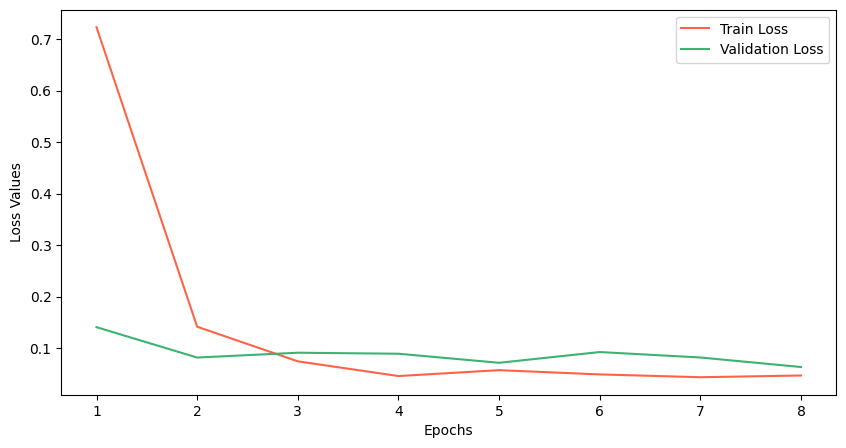

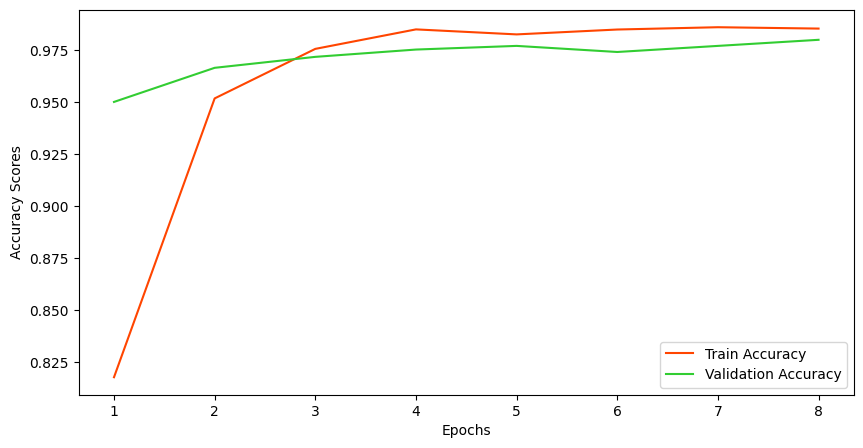

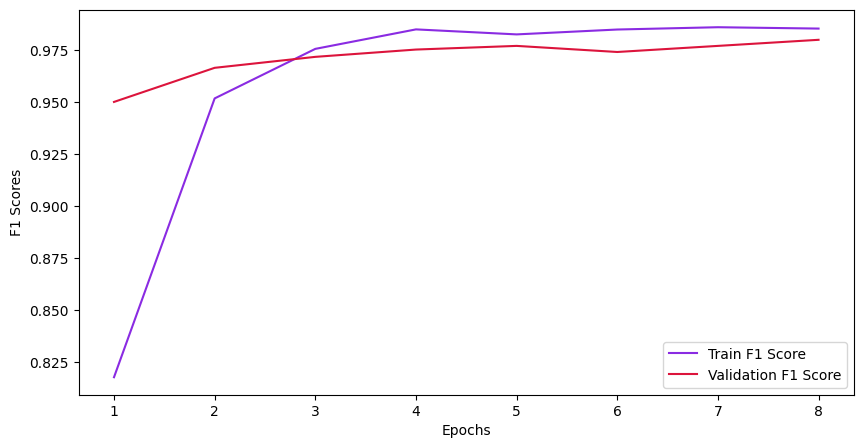

In [6]:
class PlotLearningCurves:
    
    def __init__(self, tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s):
        
        self.tr_losses, self.val_losses, self.tr_accs, self.val_accs, self.tr_f1s, self.val_f1s = tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s
        
    def plot(self, array_1, array_2, label_1, label_2, color_1, color_2):
        
        plt.plot(array_1, label = label_1, c = color_1)
        plt.plot(array_2, label = label_2, c = color_2)
        
    def create_figure(self): 
        plt.figure(figsize = (10, 5))
    
    def decorate(self, ylabel, xlabel = "Epochs"): 
        
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(ticks = np.arange(len(self.tr_accs)), labels = [i for i in range(1, len(self.tr_accs) + 1)])
        plt.legend()
        plt.show()      
        
    def visualize(self):
        
        # Figure 1: Loss Curves with more colorful colors
        self.create_figure()
        self.plot(array_1 = self.tr_losses, array_2 = self.val_losses, label_1 = "Train Loss", label_2 = "Validation Loss", color_1 = "#FF6347", color_2 = "#3CB371")  # Tomato and MediumSeaGreen
        self.decorate(ylabel = "Loss Values")
        
        # Figure 2: Accuracy Curves with more colorful colors
        self.create_figure()
        self.plot(array_1 = self.tr_accs, array_2 = self.val_accs, label_1 = "Train Accuracy", label_2 = "Validation Accuracy", color_1 = "#FF4500", color_2 = "#32CD32")  # OrangeRed and LimeGreen
        self.decorate(ylabel = "Accuracy Scores")
        
        # Figure 3: F1 Score Curves with more colorful colors
        self.create_figure()
        self.plot(array_1 = self.tr_f1s, array_2 = self.val_f1s, label_1 = "Train F1 Score", label_2 = "Validation F1 Score", color_1 = "#8A2BE2", color_2 = "#DC143C")  # BlueViolet and Crimson
        self.decorate(ylabel = "F1 Scores")
        
PlotLearningCurves(tr_losses=trainer.tr_losses, val_losses=trainer.val_losses, tr_accs=trainer.tr_accs, val_accs=trainer.val_accs, tr_f1s=trainer.tr_f1s, val_f1s=trainer.val_f1s).visualize()

<div style='background-color: #fff0db; border: 3px solid #FFA07A; border-radius: 10px; padding: 6px; text-align: center;'>
<font size="+1.8" color="#FF4500"><b>✅ 6. Inference and AI Model Performance Analysis with GradCAM ✅</b></font>
</div>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38339 sha256=a31e7bc76305d42857c7560f90b775a5b0100480b07a118f12516e1a869384c3
  Stored in directory: /root/.cache/pip/wheels/3c/6c/04/9a543775e9f25f6c441180a552456f1696167439459730ff87
Successfully built grad-cam


<ipython-input-7-bc0c4ca33da6>:125: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{save_dir}/{save_prefix}_best_model.pth"))
Inference: 38

Accuracy of the model on the test data -> 0.982


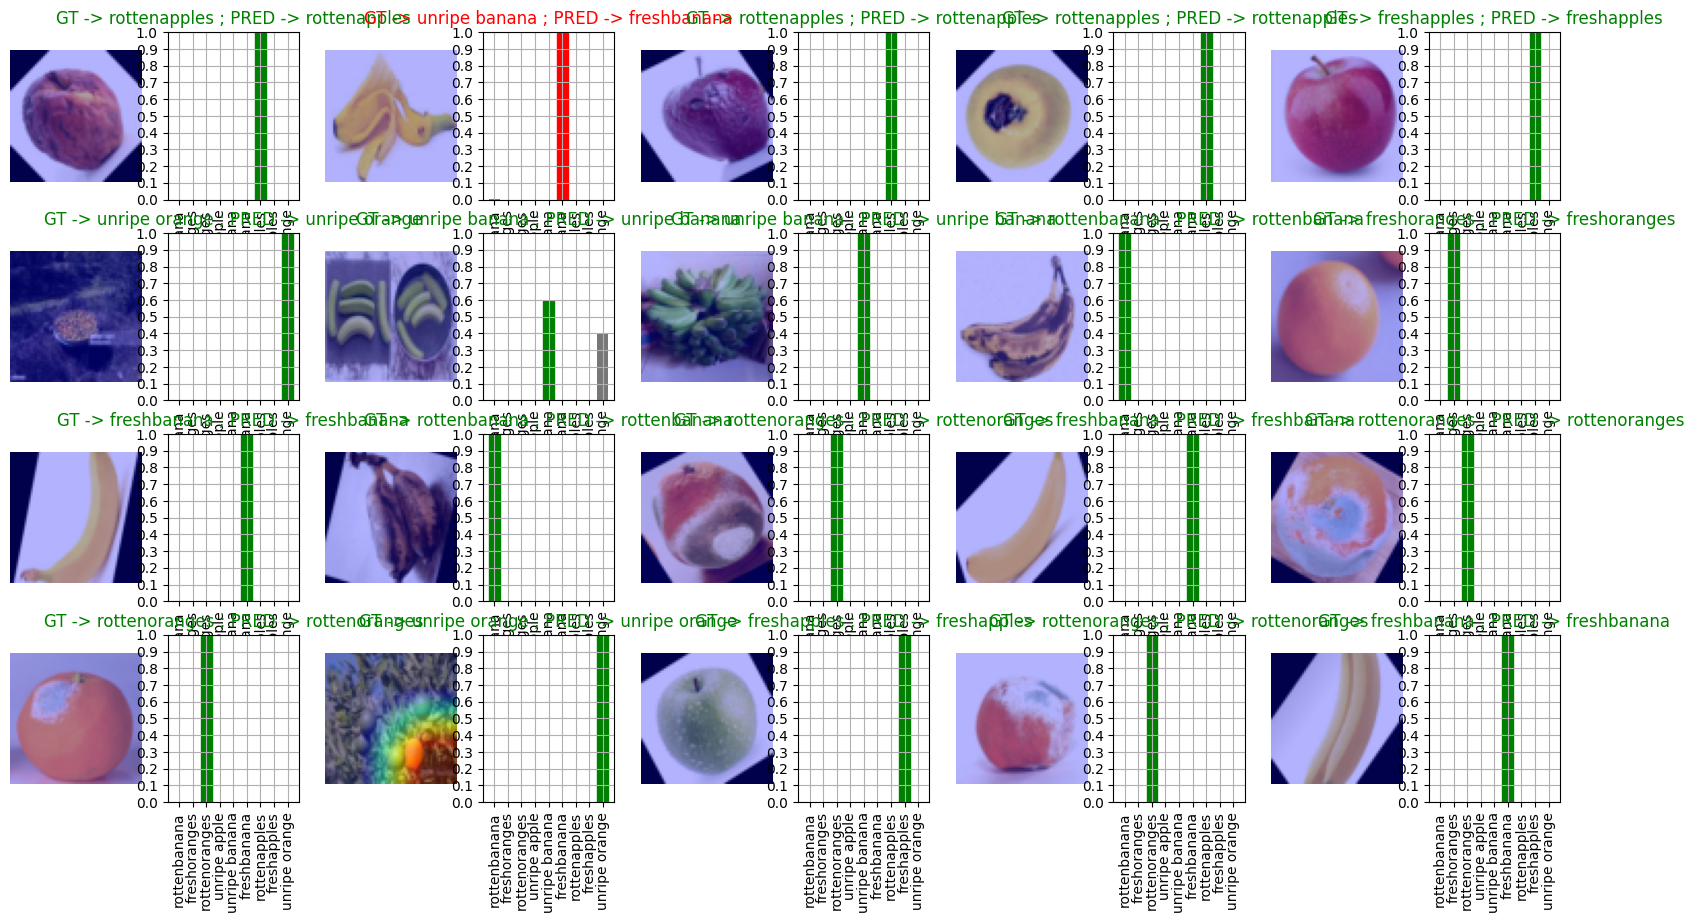

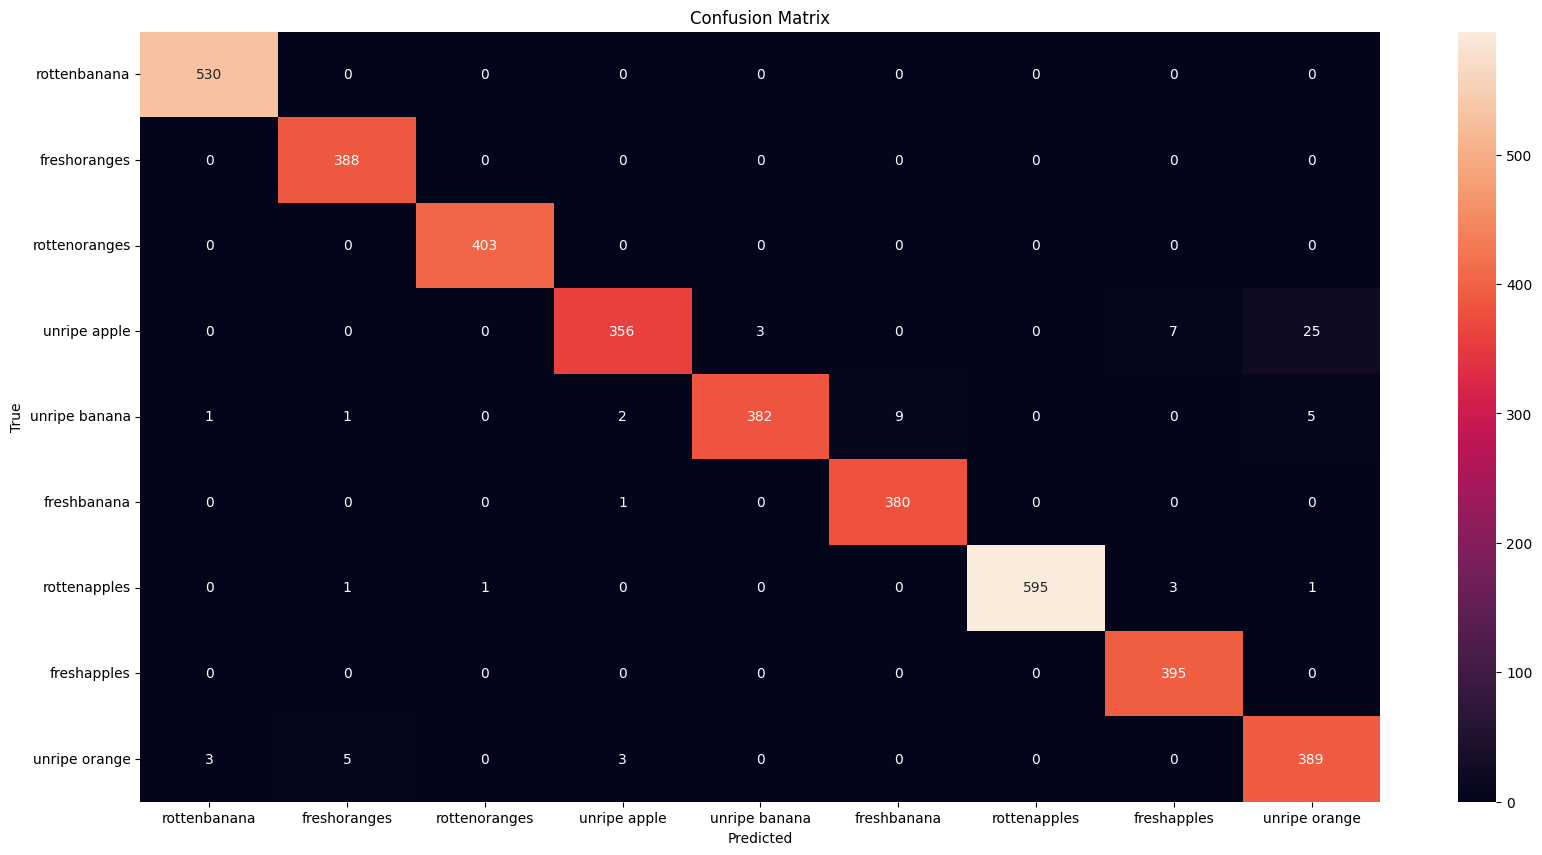

In [7]:
!pip install grad-cam==1.4.6
import cv2, random
import seaborn as sns
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

class Denormalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Reverse the normalization applied to the image tensor.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

class ModelInferenceVisualizer:
    def __init__(self, model, device, class_names=None, im_size=224, mean = mean, std = std):
        
        self.denormalize = Denormalize(mean, std)
        self.model = model
        self.device = device
        self.class_names = class_names
        self.im_size = im_size
        self.model.eval()  # Set model to evaluation mode

    def tensor_to_image(self, tensor):
        """
        Convert a normalized tensor to a denormalized image array.
        """
        tensor = self.denormalize(tensor)  # Denormalize the tensor
        tensor = tensor.permute(1, 2, 0)  # Convert from CxHxW to HxWxC
        return (tensor.cpu().numpy() * 255).astype(np.uint8)

    def plot_value_array(self, logits, gt, class_names):
        """Plot the prediction probability array."""
        probs = torch.nn.functional.softmax(logits, dim=1)
        pred_class = torch.argmax(probs, dim=1)
        
        plt.grid(visible=True)
        plt.xticks(range(len(class_names)), class_names, rotation='vertical')
        plt.yticks(np.arange(0.0, 1.1, 0.1))
        bars = plt.bar(range(len(class_names)), [p.item() for p in probs[0]], color="#777777")
        plt.ylim([0, 1])
        if pred_class.item() == gt:
            bars[pred_class].set_color('green')
        else:
            bars[pred_class].set_color('red')

    def generate_cam_visualization(self, image_tensor):
        """Generate GradCAM visualization."""
        cam = GradCAMPlusPlus(model=self.model, target_layers=[self.model.features[-1]], use_cuda=self.device == "cuda")
        grayscale_cam = cam(input_tensor=image_tensor.unsqueeze(0))[0, :]
        return grayscale_cam

    def infer_and_visualize(self, test_dl, num_images=5, rows=2):
        """Perform inference and visualize predictions along with GradCAM."""
        preds, images, lbls, logitss = [], [], [], []
        accuracy, count = 0, 1

        with torch.no_grad():
            for idx, batch in tqdm(enumerate(test_dl), desc="Inference"):
                # if idx == 20: break
                im, gt = TrainValidation.to_device(batch, device = self.device)                
                logits = self.model(im)
                pred_class = torch.argmax(logits, dim=1)
                accuracy += (pred_class == gt).sum().item()
                images.append(im[0])
                logitss.append(logits[0])
                preds.append(pred_class[0].item())
                lbls.append(gt[0].item())

        print(f"Accuracy of the model on the test data -> {(accuracy / len(test_dl.dataset)):.3f}")

        plt.figure(figsize=(20, 10))
        indices = [random.randint(0, len(images) - 1) for _ in range(num_images)]
        for idx, index in enumerate(indices):
            # Convert and denormalize image
            im = self.tensor_to_image(images[index].squeeze())
            pred_idx = preds[index]
            gt_idx = lbls[index]

            # Display image
            plt.subplot(rows, 2 * num_images // rows, count)
            count += 1
            plt.imshow(im, cmap="gray")
            plt.axis("off")

            # GradCAM visualization
            grayscale_cam = self.generate_cam_visualization(images[index])
            visualization = show_cam_on_image(im / 255, grayscale_cam, image_weight=0.4, use_rgb=True)
            plt.imshow(cv2.resize(visualization, (self.im_size, self.im_size), interpolation=cv2.INTER_LINEAR), alpha=0.7, cmap='jet')
            plt.axis("off")

            # Prediction probability array
            logits = logitss[index]
            if logits.dim() == 1:  # If 1D, add a batch dimension
                logits = logits.unsqueeze(0)
            plt.subplot(rows, 2 * num_images // rows, count)
            count += 1
            self.plot_value_array(logits=logits, gt=gt_idx, class_names=self.class_names)

            # Title with GT and Prediction
            if self.class_names:
                gt_name = self.class_names[gt_idx]
                pred_name = self.class_names[pred_idx]
                color = "green" if gt_name == pred_name else "red"
                plt.title(f"GT -> {gt_name} ; PRED -> {pred_name}", color=color)

        # Plot confusion matrix
        plt.figure(figsize=(20, 10))
        cm = confusion_matrix(lbls, preds)
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

model = timm.create_model(model_name = model_name, pretrained = False, num_classes = len(classes)).to(device)
model.load_state_dict(torch.load(f"{save_dir}/{save_prefix}_best_model.pth"))
inference_visualizer = ModelInferenceVisualizer(
    model=model,
    device=device,
    class_names=list(classes.keys()),  # List of class names
    im_size=im_size
)

inference_visualizer.infer_and_visualize(ts_dl, num_images = 20, rows = 4)